<img src="https://www.austral.edu.ar/wp-content/uploads/2022/10/facultades-horizontales-03.png" width="50%" alt="Universidad Austral - Facultad de Ingeniería">

## Maestría en Ciencia de Datos 2024/2025

### Análisis de Series Temporales - Trabajo práctico N° 1

Integrantes:
- Cancelas, Martín.
-	Fiipuzzi, Juan Manuel.
-	Gallardo, Ezequiel.
-	Nicolau, Jorge.



[https://colab.research.google.com/drive/1bwqSAtlE3GMqG3Xzi-OCgQFtivW-a9Nm?usp=sharing](https://colab.research.google.com/drive/1bwqSAtlE3GMqG3Xzi-OCgQFtivW-a9Nm?usp=sharing)



El presente trabajo aborda la necesidad del Banco Central de la República Argentina (BCRA) de contar con pronósticos robustos y confiables sobre la Circulación Monetaria, definida como el stock de billetes y monedas en poder del público y los bancos. Esta capacidad predictiva es fundamental para la óptima asignación de recursos públicos en la impresión y logística de billetes, buscando evitar tanto la escasez como el exceso de numerario y guiar la decisión de elaborar nuevas denominaciones. En el contexto económico argentino, marcado por períodos de inestabilidad económica y la influencia de variables como el crecimiento económico, la política monetaria y la inflación, la precisión de estos pronósticos es vital. Las demoras pasadas en la emisión de billetes de mayor denominación han generado ineficiencias y costos adicionales para las entidades financieras, subrayando la urgencia de estas predicciones.

Para lograr estos pronósticos, el estudio se centra en el Análisis de Series Temporales, dado que la Circulación Monetaria y otras variables económicas exhiben correlación e "inercia" que requieren métodos de inferencia específicos. Una propiedad fundamental es la estacionariedad, que se evalúa mediante Funciones de Autocovarianza (FAS), Autocorrelación (FAC) y Autocorrelación Parcial (FACP), y se somete a pruebas formales de raíces unitarias. Los análisis preliminares confirmaron que la Circulación Monetaria, la Tasa de Plazo Fijo y el IPC son series no estacionarias. Para la Circulación Monetaria, se aplicó una transformación logarítmica para estabilizar la varianza, seguida de una diferenciación integrada y estacional, logrando así que la serie transformada sea estacionaria y apta para el modelado SARIMA.

En esta línea, se estimaron modelos SARIMA con estacionalidades de 6 y 12 meses para capturar patrones estacionales relevantes, evaluando el desempeño mediante métricas de error y criterios de información. Posteriormente, se avanzó hacia modelos SARIMA-X incorporando regresores exógenos, primero incluyendo todas las variables disponibles y luego restringiendo el modelo únicamente a la tasa de plazo fijo. Se mantuvo la comparación entre estacionalidades semestrales y anuales. Si bien el modelo con estacionalidad anual mostró mejores métricas de error, el análisis económico sugiere que la estacionalidad semestral (junio-diciembre) — coincidente con pagos de aguinaldos — refleja de forma más realista el comportamiento de la circulación monetaria. Por ello, se propone continuar refinando el modelo SARIMA-X (0,1,1)  (1,1,1,6) con tasa de interés como única regresora, buscando mayor precisión y parsimonia sin perder interpretabilidad.


### Instalación e importación de librerías necesarias para el trabajo.

In [ ]:
import requests
import pandas as pd
import urllib3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import io
import numpy as np
import warnings
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.api import OLS, add_constant
from statsmodels.graphics.gofplots import qqplot
from datetime import datetime
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Obtención de series temporales con variables de interés.

### Variables del BCRA
**Circulación Monetaria y Tasa de Plazo Fijo a 30-44 días en TNA**

In [ ]:
def descargar_variable(var_id, desde, hasta):
    url = f"https://api.bcra.gob.ar/estadisticas/v3.0/monetarias/{var_id}?desde={desde}&hasta={hasta}"
    resp = requests.get(url, verify=False)
    resultados = resp.json().get("results", [])
    if not resultados:
        raise ValueError(f"No se encontraron datos para la variable {var_id} en rango {desde} a {hasta}")
    df = pd.DataFrame(resultados)
    df['fecha'] = pd.to_datetime(df['fecha'])
    df.sort_values('fecha', inplace=True)
    df.set_index('fecha', inplace=True)
    return df

rangos = [
    ("2017-01-01", "2021-04-09"),
    ("2021-04-10", "2025-06-30")
]

variables = {
    67: "Billetes y Monedas en poder del público",
    68: "Billetes y Monedas en poder de las Entidades Financieras",
    128: "Tasa de Plazo Fijo a 30-44 días"
}

data = {}

for var_id, nombre in variables.items():
    try:
        df_list = []
        for desde, hasta in rangos:
            df_parcial = descargar_variable(var_id, desde, hasta)
            df_list.append(df_parcial)
        df_var = pd.concat(df_list)
        df_var = df_var[~df_var.index.duplicated(keep='first')]
        data[var_id] = df_var['valor']
        print(f"✅ {nombre} cargada correctamente, {len(df_var)} valores")
    except Exception as e:
        print(f"❌ Error al cargar la variable {nombre}, el error es: {e}")


✅ Billetes y Monedas en poder del público cargada correctamente, 2000 valores
✅ Billetes y Monedas en poder de las Entidades Financieras cargada correctamente, 2000 valores
✅ Tasa de Plazo Fijo a 30-44 días cargada correctamente, 2000 valores


### Computo mensual de variables BCRA
**Circulación Monetaria**

In [ ]:
try:
    df_combined = pd.DataFrame(data)
    # La circulación monetaria es la suma de billetes y monedas en posesión
    # del público más los que están presentes en entidades financiaeras
    df_combined['circulacion_monetaria'] = (df_combined[67] + df_combined[68]) * 1_000_000
    circulacion_mensual = df_combined['circulacion_monetaria'].resample('MS').mean()
    print(f"✅ Circulación Monetaria promedio mensual calculada correctamente, {len(circulacion_mensual)} valores")
except Exception as e:
    print(f"❌ Error al calcular Circulación Monetaria, el error es: {e}")

✅ Circulación Monetaria promedio mensual calculada correctamente, 101 valores


In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
display(circulacion_mensual.head().to_frame(name='Circulación Monetaria ($)').applymap(lambda x: f"${x:,.0f}"))

,Circulación Monetaria ($)
fecha,
2017-02-01,"$599,383,000,000"
2017-03-01,"$592,143,954,545"
2017-04-01,"$590,304,277,778"
2017-05-01,"$587,665,952,381"
2017-06-01,"$606,629,476,190"


**Tasa de Plazo Fijo a 30-44 días.**


In [ ]:
try:
    tasa_pf_mensual = df_combined[128].resample('MS').mean()
    print(f"✅ Tasa de Plazo Fijo calculada correctamente, {len(tasa_pf_mensual)} valores")
except Exception as e:
    print(f"❌ Error al calcular Tasa de Plazo Fijo, el error es: {e}")


✅ Tasa de Plazo Fijo calculada correctamente, 101 valores


In [ ]:
display(tasa_pf_mensual.head().to_frame(name="Tasa Plazo Fijo (%)").applymap(lambda x: f"{x:.2f}%"))

,Tasa Plazo Fijo (%)
fecha,
2017-02-01,18.51%
2017-03-01,18.06%
2017-04-01,17.76%
2017-05-01,18.08%
2017-06-01,18.20%


### Variables del INDEC
**IPC: Indice de Precios al Consumidor a Nivel Nacional**

In [ ]:
try:
    url_ipc = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_06_25.xls"
    response_ipc = requests.get(url_ipc)
    archivo_excel = io.BytesIO(response_ipc.content)

    df_fechas = pd.read_excel(archivo_excel, header=None, skiprows=5, nrows=1)
    df_valores = pd.read_excel(archivo_excel, header=None, skiprows=9, nrows=1)
    fechas_raw = df_fechas.iloc[0, 1:]
    valores_raw = df_valores.iloc[0, 1:]
    fechas = pd.to_datetime(fechas_raw, format='%b-%y')

    ipc_df = pd.DataFrame({'fecha': fechas, 'ipc': valores_raw.values})
    ipc_df = ipc_df.dropna(subset=['ipc'])
    ipc_df['ipc'] = pd.to_numeric(ipc_df['ipc'], errors='coerce')
    ipc_df.set_index('fecha', inplace=True)
    ipc_mensual = ipc_df.resample('MS').mean()
    print(f"✅ IPC Nacional cargado correctamente, {len(ipc_mensual)} valores")
except Exception as e:
    print(f"❌ Error al cargar el IPC Nacional, el error es: {e}")

✅ IPC Nacional cargado correctamente, 101 valores


In [ ]:
display(ipc_mensual["ipc"].head().apply(lambda x: f"{x:.2f}%").to_frame(name="IPC Nacional (%)"))

,IPC Nacional (%)
fecha,
2017-01-01,1.60%
2017-02-01,2.10%
2017-03-01,2.40%
2017-04-01,2.70%
2017-05-01,1.40%


**EMAE: Estimador Mensual de la Actividad Económica**

In [ ]:
try:
    url_emae = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_emae_mensual_base2004.xls"
    response_emae = requests.get(url_emae)
    archivo_excel = io.BytesIO(response_emae.content)

    em_raw = pd.read_excel(archivo_excel, header=None, skiprows=5, usecols="A:C")
    em_raw.columns = ['anio', 'mes', 'emae']
    em_raw['anio'] = em_raw['anio'].ffill()
    em_raw = em_raw.dropna(subset=['mes', 'emae'])

    meses_dict = {
        'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4,
        'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8,
        'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
    }

    em_raw['mes_num'] = em_raw['mes'].str.strip().map(meses_dict)
    em_raw['fecha'] = pd.to_datetime(dict(year=em_raw['anio'].astype(int),
                                          month=em_raw['mes_num'],
                                          day=1))

    start_date = pd.to_datetime("2017-01-01")
    end_date = pd.to_datetime("2025-06-30")

    emae_df = em_raw.loc[(em_raw['fecha'] >= start_date) & (em_raw['fecha'] <= end_date), ['fecha', 'emae']]
    emae_df.set_index('fecha', inplace=True)
    emae_df = emae_df.sort_index()
    print(f"✅ EMAE cargado correctamente, {len(emae_df)} valores")
except Exception as e:
    print(f"❌ Error al cargar el EMAE, el error es: {e}")

✅ EMAE cargado correctamente, 101 valores


In [ ]:
display(emae_df["emae"].head().apply(lambda x: f"{x:.2f}").to_frame(name="EMAE"))

,EMAE
fecha,
2017-01-01,136.63
2017-02-01,132.16
2017-03-01,152.62
2017-04-01,151.95
2017-05-01,168.39


### Visualización de las variables de interés.
**Circulación Monetaria**

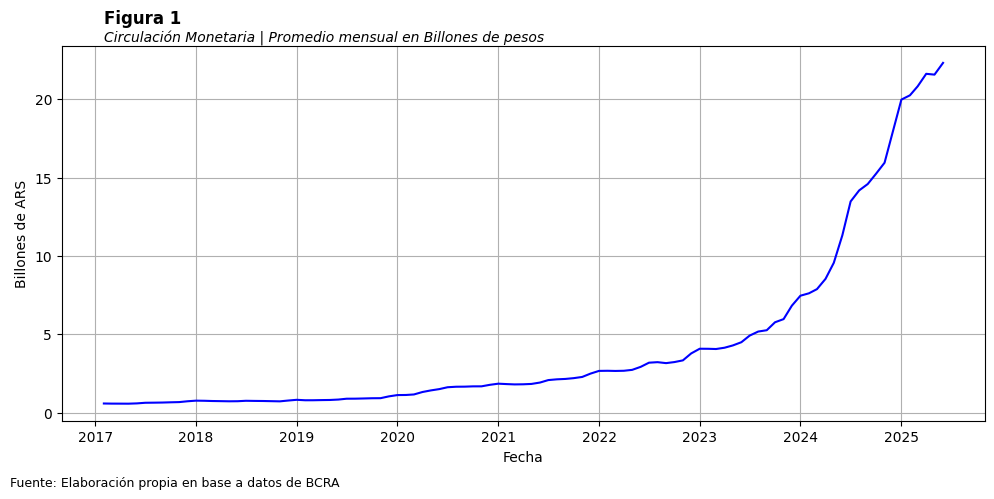

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(circulacion_mensual.index, circulacion_mensual.values / 1_000_000_000_000, color='blue')
plt.title('')
plt.text(x=circulacion_mensual.index.min(), y=plt.ylim()[1]*1.05,
         s="Figura 1", fontsize=12, fontweight='bold', ha='left', va='bottom')
plt.text(x=circulacion_mensual.index.min(), y=plt.ylim()[1]*1.00,
         s="Circulación Monetaria | Promedio mensual en Billones de pesos", fontsize=10,
         fontstyle='italic', ha='left', va='bottom')
plt.xlabel('Fecha')
plt.ylabel('Billones de ARS')
plt.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a datos de BCRA", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

**Tasa de Plazo Fijo a 30-44 días**

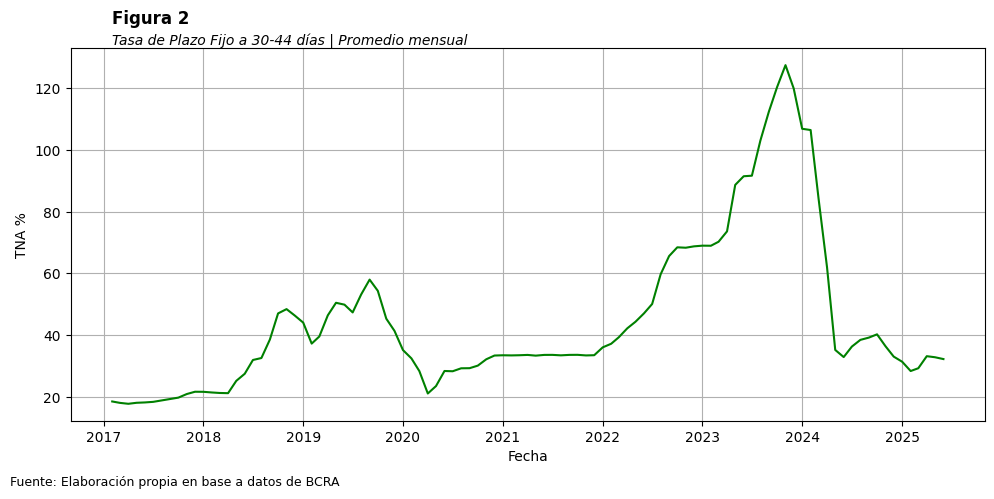

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(tasa_pf_mensual.index, tasa_pf_mensual.values, color='green')
plt.title('')
ylim = plt.ylim()
plt.text(x=tasa_pf_mensual.index.min(), y=ylim[1]*1.05,
         s="Figura 2", fontsize=12, fontweight='bold', ha='left', va='bottom')
plt.text(x=tasa_pf_mensual.index.min(), y=ylim[1]*1.00,
         s="Tasa de Plazo Fijo a 30-44 días | Promedio mensual", fontsize=10,
         fontstyle='italic', ha='left', va='bottom')
plt.xlabel('Fecha')
plt.ylabel('TNA %')
plt.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a datos de BCRA", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

**IPC Nacional**

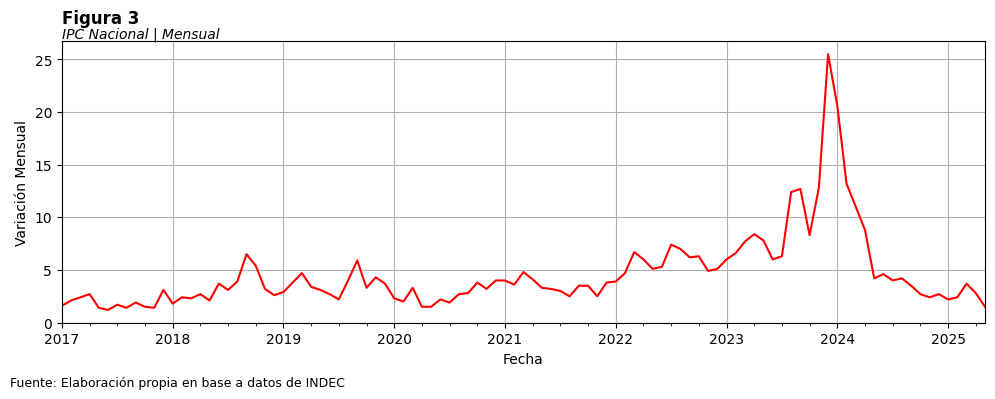

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ipc_mensual.plot(ax=ax, color='red', legend=False)
ax.set_title('')
ylim = ax.get_ylim()
ax.text(ipc_mensual.index.min(), ylim[1]*1.05,
        "Figura 3", fontsize=12, fontweight='bold', ha='left', va='bottom')
ax.text(ipc_mensual.index.min(), ylim[1]*1.00,
        "IPC Nacional | Mensual", fontsize=10,
        fontstyle='italic', ha='left', va='bottom')
ax.set_xlabel('Fecha')
ax.set_ylabel('Variación Mensual')
ax.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a datos de INDEC", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

**EMAE**


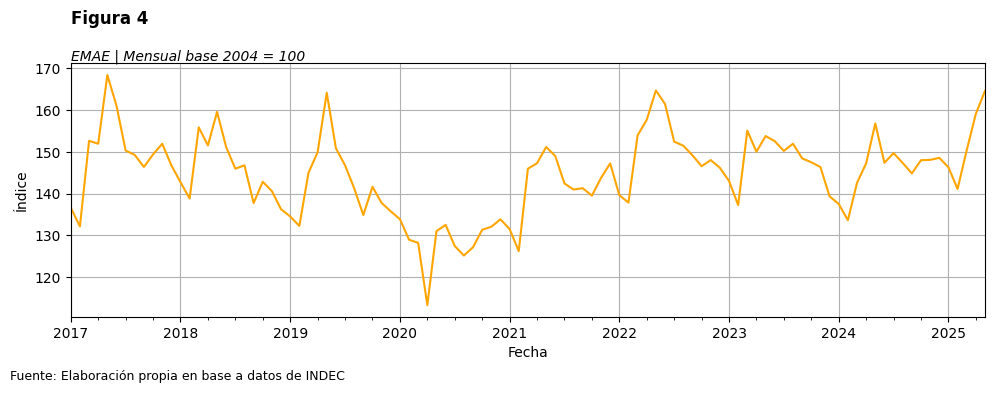

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
emae_df.plot(ax=ax, color='orange', legend=False)
ax.set_title('')
ylim = ax.get_ylim()
ax.text(emae_df.index.min(), ylim[1]*1.05,
        "Figura 4", fontsize=12, fontweight='bold', ha='left', va='bottom')
ax.text(emae_df.index.min(), ylim[1]*1.00,
        "EMAE | Mensual base 2004 = 100", fontsize=10,
        fontstyle='italic', ha='left', va='bottom')
ax.set_xlabel('Fecha')
ax.set_ylabel('Índice')
ax.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a datos de INDEC", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

### Funciones de Autocovarianzas (FAS), Autocorrelación (FAC) y Autocorrelación Parcial (FACP) de las variables

In [ ]:
def autocovariance(series, lag):
    series = np.asarray(series)
    n = len(series)
    mean = np.mean(series)
    if lag >= n:
        return np.nan
    return np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)

def autocorrelation(series, lag):
    gamma_0 = autocovariance(series, 0)
    if gamma_0 == 0:
        return np.nan
    return autocovariance(series, lag) / gamma_0

def graficar_fac_fas_facp(serie, fig_num, titulo, subtitulo, color, lags=36):
    serie = serie.dropna()
    max_lags = min(lags, len(serie) // 2 - 1)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # FAS
    lag_range = np.arange(1, max_lags + 1)
    autocovs = [autocovariance(serie, lag) for lag in lag_range]
    axs[0].stem(lag_range, autocovs, basefmt=" ", linefmt=color, markerfmt=color)
    axs[0].set_title('FAS - Función de Autocovarianzas', fontsize=12)
    axs[0].set_xlabel('Rezago')
    axs[0].set_ylabel('Valor')
    axs[0].grid()

    # FAC
    plot_acf(serie, lags=max_lags, ax=axs[1], alpha=0.05, color=color)
    axs[1].set_title('FAC - Función de Autocorrelación', fontsize=12)
    axs[1].set_xlabel('Rezago')
    axs[1].grid()
    for line in axs[1].lines:
        line.set_color(color)
        line.set_markerfacecolor(color)
        line.set_markeredgecolor(color)
    for patch in axs[1].collections:
        patch.set_facecolor(color)
        patch.set_alpha(0.15)

    # FACP
    plot_pacf(serie, lags=max_lags, ax=axs[2], method="ywm", alpha=0.05, color=color)
    axs[2].set_title('FACP - Función de Autocorrelación Parcial', fontsize=12)
    axs[2].set_xlabel('Rezago')
    axs[2].grid()
    for line in axs[2].lines:
        line.set_color(color)
        line.set_markerfacecolor(color)
        line.set_markeredgecolor(color)
    for patch in axs[2].collections:
        patch.set_facecolor(color)
        patch.set_alpha(0.15)

    plt.suptitle(f"Figura {fig_num}", fontsize=14, fontweight='bold', x=0.01, ha='left')
    fig.text(0.015, 0.87, subtitulo, fontsize=11, fontstyle='italic', ha='left')
    plt.tight_layout(rect=[0, 0.04, 1, 0.85])
    plt.show()

**FAS, FAC y FACP de Circulación Monteria**

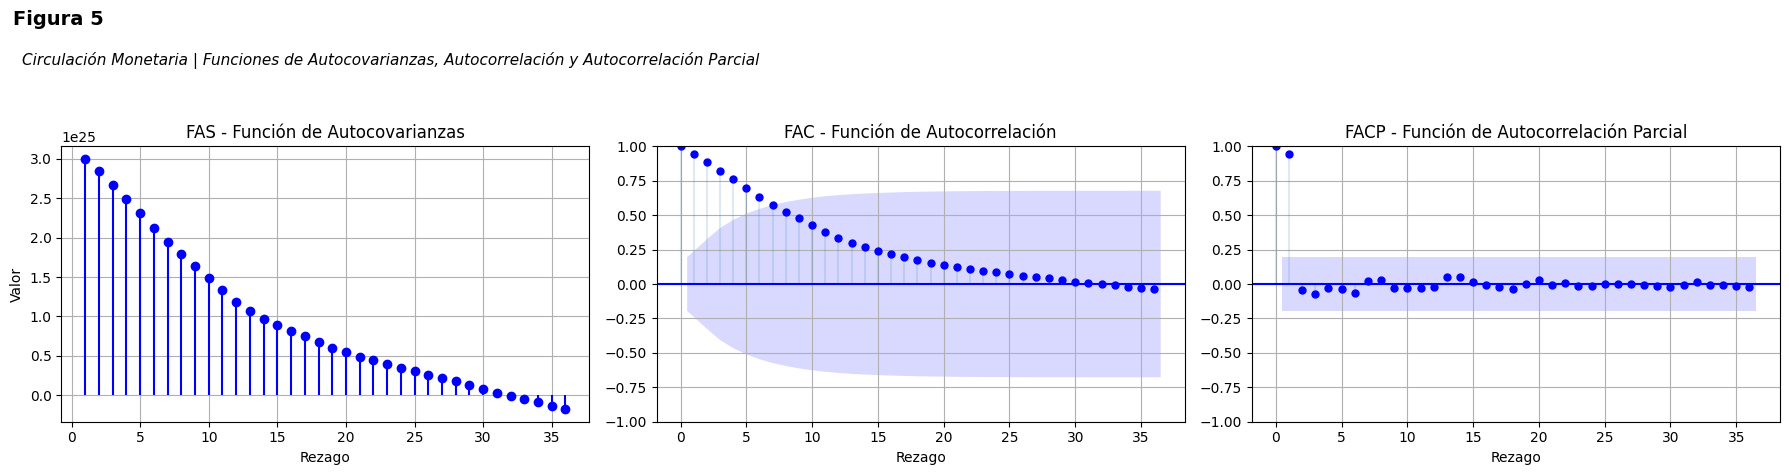

In [ ]:
graficar_fac_fas_facp(
    circulacion_mensual,
    fig_num=5,
    titulo="FAC / FAS / FACP - Circulación Monetaria",
    subtitulo="Circulación Monetaria | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='blue'
)

**FAS, FAC y FACP de Tasa de Plazo Fijo a 30-44 días**

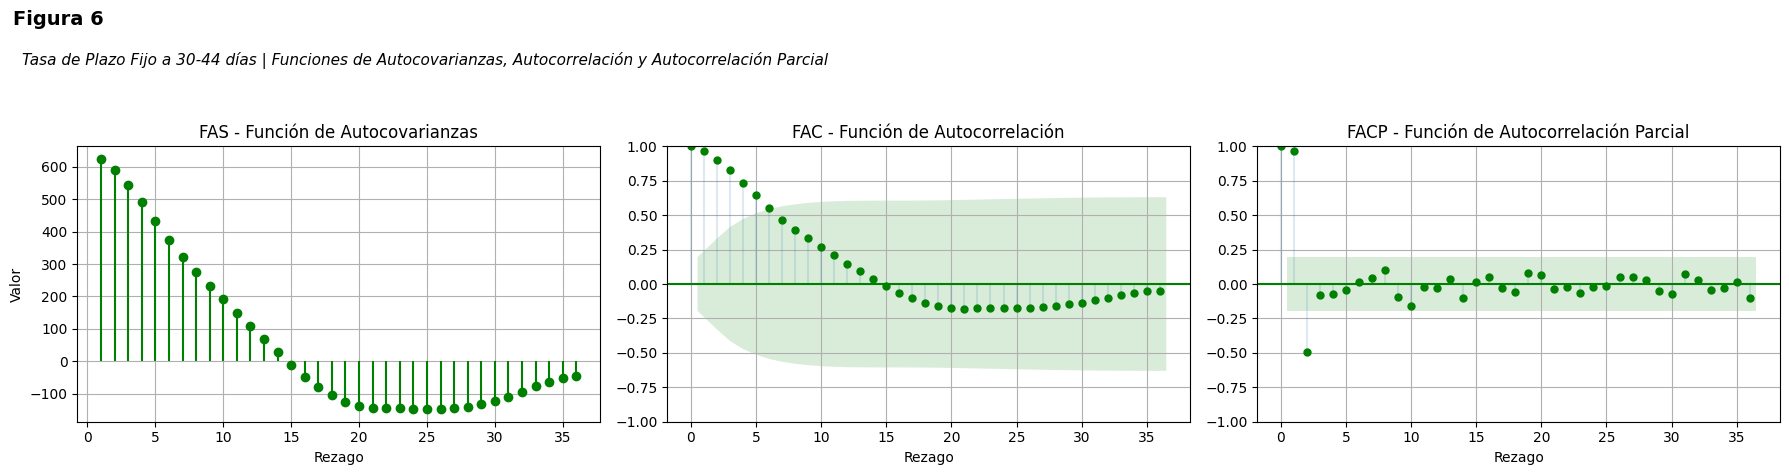

In [ ]:
graficar_fac_fas_facp(
    tasa_pf_mensual,
    fig_num=6,
    titulo="FAC / FAS / FACP - Tasa de Plazo Fijo",
    subtitulo="Tasa de Plazo Fijo a 30-44 días | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='green'
)

**FAS, FAC y FACP de IPC Nacional**

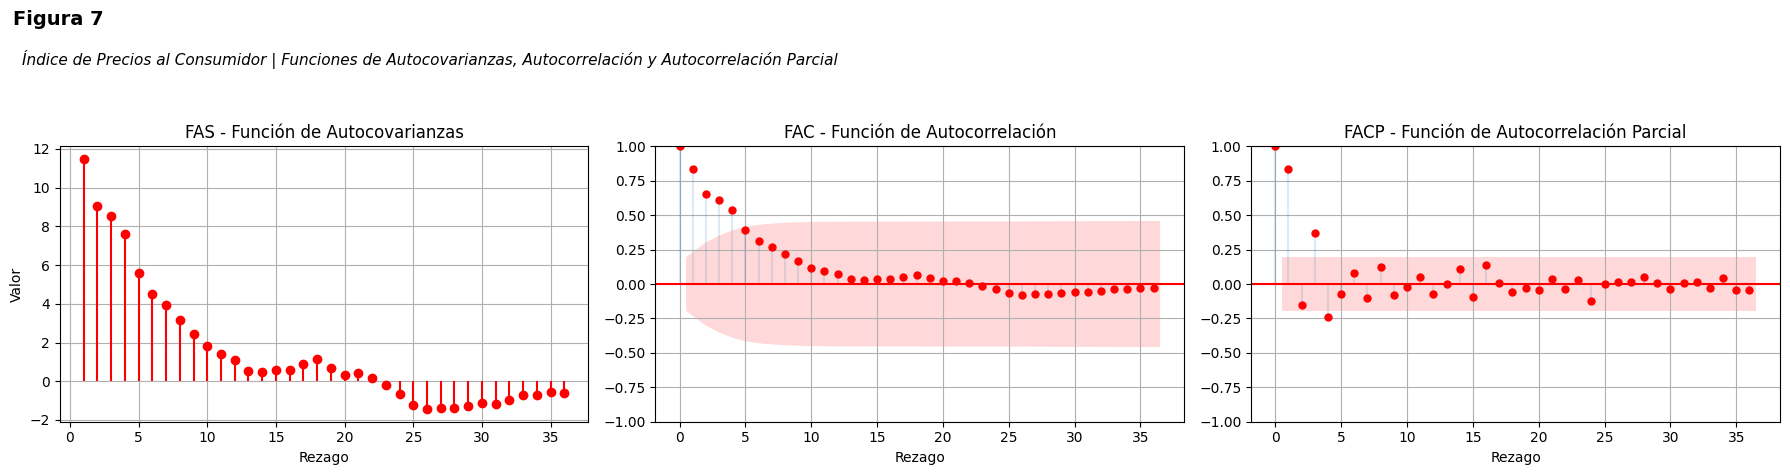

In [ ]:
graficar_fac_fas_facp(
    ipc_mensual['ipc'],
    fig_num=7,
    titulo="FAC / FAS / FACP - IPC Nacional",
    subtitulo="Índice de Precios al Consumidor | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='red'
)

**FAS, FAC y FACP de Estimador Mensual de Actividad Económica**

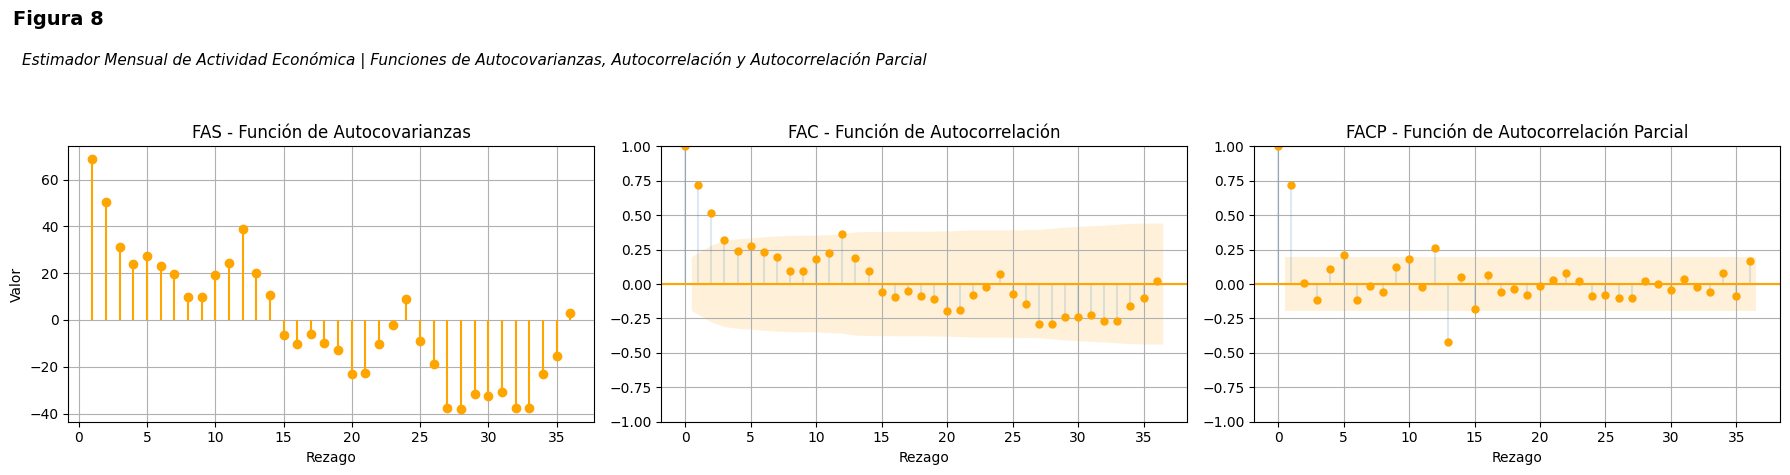

In [ ]:
graficar_fac_fas_facp(
    emae_df['emae'],
    fig_num=8,
    titulo="FAC / FAS / FACP - EMAE",
    subtitulo="Estimador Mensual de Actividad Económica | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='orange'
)

### Pruebas de Raíces Unitarias.

In [ ]:
def test_dickey_fuller_simple(serie):
    y = serie.dropna().values
    dy = np.diff(y)
    y_lag = y[:-1]
    X = add_constant(y_lag)
    modelo = OLS(dy, X).fit()
    stat = modelo.tvalues[1]
    crit = {'1%': -3.43, '5%': -2.86, '10%': -2.57}
    conc = 'Estacionaria' if stat < crit['5%'] else 'No Estacionaria'
    return stat, crit, conc

def test_adf(serie):
    resultado = adfuller(serie.dropna(), autolag='AIC')
    stat = resultado[0]
    pval = resultado[1]
    crit = resultado[4]
    conc = 'Estacionaria' if pval < 0.05 else 'No Estacionaria'
    return stat, pval, crit, conc

def test_kpss_test(serie):
    resultado = kpss(serie.dropna(), regression='c', nlags='auto')
    stat = resultado[0]
    pval = resultado[1]
    crit = resultado[3]
    conc = 'Estacionaria' if pval >= 0.05 else 'No Estacionaria'
    return stat, pval, crit, conc

def aplicar_tests_a_series(series_dict, nombre_columna='Variable'):
    resultados = []
    for nombre, serie in series_dict.items():
        df_stat, df_crit, df_conc = test_dickey_fuller_simple(serie)
        adf_stat, adf_p, adf_crit, adf_conc = test_adf(serie)
        kpss_stat, kpss_p, kpss_crit, kpss_conc = test_kpss_test(serie)
        resultados.append({
            nombre_columna: nombre,
            'DF estadístico': round(df_stat, 4),
            'DF 1%': df_crit['1%'], 'DF 5%': df_crit['5%'], 'DF 10%': df_crit['10%'],
            'DF conclusión': df_conc,
            'ADF estadístico': round(adf_stat, 4), 'ADF p-valor': round(adf_p, 4),
            'ADF 1%': adf_crit['1%'], 'ADF 5%': adf_crit['5%'], 'ADF 10%': adf_crit['10%'],
            'ADF conclusión': adf_conc,
            'KPSS estadístico': round(kpss_stat, 4), 'KPSS p-valor': round(kpss_p, 4),
            'KPSS 1%': kpss_crit['1%'], 'KPSS 5%': kpss_crit['5%'], 'KPSS 10%': kpss_crit['10%'],
            'KPSS conclusión': kpss_conc
        })
    return pd.DataFrame(resultados)

def reorganizar_resultados_largo(df_resultados, nombre_columna='Variable'):
    filas = []
    for _, row in df_resultados.iterrows():
        etiqueta = row[nombre_columna]
        for nivel in ['1%', '5%', '10%']:
            filas.append({
                nombre_columna: etiqueta,
                'Significancia': nivel,
                'DF estadístico': row['DF estadístico'],
                'DF crítico': row[f'DF {nivel}'],
                'DF conclusión': row['DF conclusión'],
                'ADF estadístico': row['ADF estadístico'],
                'ADF p-valor': row['ADF p-valor'],
                'ADF crítico': row[f'ADF {nivel}'],
                'ADF conclusión': row['ADF conclusión'],
                'KPSS estadístico': row['KPSS estadístico'],
                'KPSS p-valor': row['KPSS p-valor'],
                'KPSS crítico': row[f'KPSS {nivel}'],
                'KPSS conclusión': row['KPSS conclusión'],
            })
    return pd.DataFrame(filas)

def mostrar_tabla_resultados(df, titulo, nombre_columna='Variable'):
    columnas_numericas = df.select_dtypes(include='number').columns
    estilos = [
        {"selector": "caption", "props": [("caption-side", "top"), ("text-align", "left"), ("font-size", "14px")]},
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ]
    styled = df.style \
        .format({col: "{:.4f}" for col in columnas_numericas}) \
        .set_table_styles(estilos) \
        .set_caption(titulo) \
        .set_properties(**{"text-align": "center"})
    return styled

In [ ]:
series_originales = {
    'Circulación Monetaria': circulacion_mensual,
    'Tasa de Plazo Fijo': tasa_pf_mensual,
    'IPC Nacional': ipc_mensual['ipc'],
    'EMAE': emae_df['emae']
}

tabla1 = aplicar_tests_a_series(series_originales, nombre_columna='Variable')
tabla1_larga = reorganizar_resultados_largo(tabla1, nombre_columna='Variable')
mostrar_tabla_resultados(tabla1_larga, "<b>Tabla 1</b><br><i>Pruebas de raíces unitarias</i>", nombre_columna='Variable')

,Variable,Significancia,DF estadístico,DF crítico,DF conclusión,ADF estadístico,ADF p-valor,ADF crítico,ADF conclusión,KPSS estadístico,KPSS p-valor,KPSS crítico,KPSS conclusión
0,Circulación Monetaria,1%,8.3817,-3.4300,No Estacionaria,2.7310,0.9991,-3.5079,No Estacionaria,1.1952,0.0100,0.7390,No Estacionaria
1,Circulación Monetaria,5%,8.3817,-2.8600,No Estacionaria,2.7310,0.9991,-2.8954,No Estacionaria,1.1952,0.0100,0.4630,No Estacionaria
2,Circulación Monetaria,10%,8.3817,-2.5700,No Estacionaria,2.7310,0.9991,-2.5848,No Estacionaria,1.1952,0.0100,0.3470,No Estacionaria
3,Tasa de Plazo Fijo,1%,-1.3247,-3.4300,No Estacionaria,-2.3915,0.1442,-3.4982,No Estacionaria,0.6137,0.0214,0.7390,No Estacionaria
4,Tasa de Plazo Fijo,5%,-1.3247,-2.8600,No Estacionaria,-2.3915,0.1442,-2.8912,No Estacionaria,0.6137,0.0214,0.4630,No Estacionaria
5,Tasa de Plazo Fijo,10%,-1.3247,-2.5700,No Estacionaria,-2.3915,0.1442,-2.5826,No Estacionaria,0.6137,0.0214,0.3470,No Estacionaria
6,IPC Nacional,1%,-2.9072,-3.4300,Estacionaria,-2.5708,0.0992,-3.4996,No Estacionaria,0.6097,0.0218,0.7390,No Estacionaria
7,IPC Nacional,5%,-2.9072,-2.8600,Estacionaria,-2.5708,0.0992,-2.8918,No Estacionaria,0.6097,0.0218,0.4630,No Estacionaria
8,IPC Nacional,10%,-2.9072,-2.5700,Estacionaria,-2.5708,0.0992,-2.5829,No Estacionaria,0.6097,0.0218,0.3470,No Estacionaria
9,EMAE,1%,-3.6006,-3.4300,Estacionaria,-1.8541,0.3539,-3.5069,No Estacionaria,0.2570,0.1000,0.7390,Estacionaria


**Raíces Unitarias con Estacionalidad mediante test de HEGY**

In [ ]:
serie = circulacion_mensual

def construir_hegy_vars(x, s=6):
    x_lag1 = x.shift(1)
    signos = np.array([(-1)**t for t in range(len(x))])
    x_lag1_alt = x_lag1 * signos
    x_lag2 = x.shift(2)
    lambdas = [2 * np.pi * j / s for j in [1, 2]]
    Z1 = 2 * np.cos(lambdas[0]) * x_lag1 - x_lag2
    W1 = x_lag1 - 2 * np.cos(lambdas[0]) * x_lag2
    Z2 = 2 * np.cos(lambdas[1]) * x_lag1 - x_lag2
    W2 = x_lag1 - 2 * np.cos(lambdas[1]) * x_lag2

    df_hegy = pd.DataFrame({
        'x_lag1': x_lag1,
        'x_lag1_alt': x_lag1_alt,
        'Z1': Z1,
        'W1': W1,
        'Z2': Z2,
        'W2': W2,
    })

    return df_hegy

hegy_vars = construir_hegy_vars(serie, s=6)

y_diff = serie - serie.shift(6)
df_reg = pd.concat([y_diff, hegy_vars], axis=1).dropna()
Y = df_reg.iloc[:, 0]
X = df_reg.iloc[:, 1:]
X = sm.add_constant(X)

modelo = sm.OLS(Y, X).fit()
print(modelo.summary())

                              OLS Regression Results                             
Dep. Variable:     circulacion_monetaria   R-squared:                       0.931
Model:                               OLS   Adj. R-squared:                  0.929
Method:                    Least Squares   F-statistic:                     410.4
Date:                   Thu, 24 Jul 2025   Prob (F-statistic):           9.71e-53
Time:                           18:44:20   Log-Likelihood:                -2699.5
No. Observations:                     95   AIC:                             5407.
Df Residuals:                         91   BIC:                             5417.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.171e+11 

### Modelos para estimar la variable Circulación Monetaria

### Transformaciones propuestas

**Diferenciación regular**



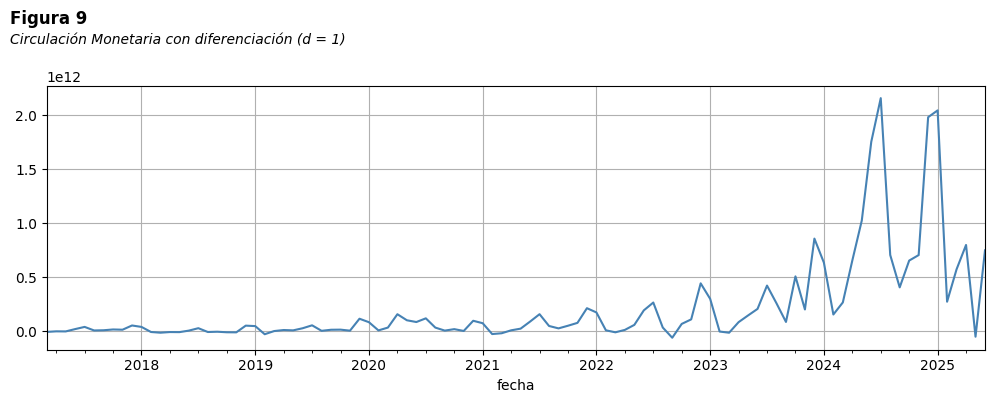

In [ ]:
serie_diff = serie.diff().dropna()

fig, ax = plt.subplots(figsize=(10, 4))
serie_diff.plot(ax=ax, color='steelblue')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 9", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria con diferenciación (d = 1)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

**Diferenciación estacional**

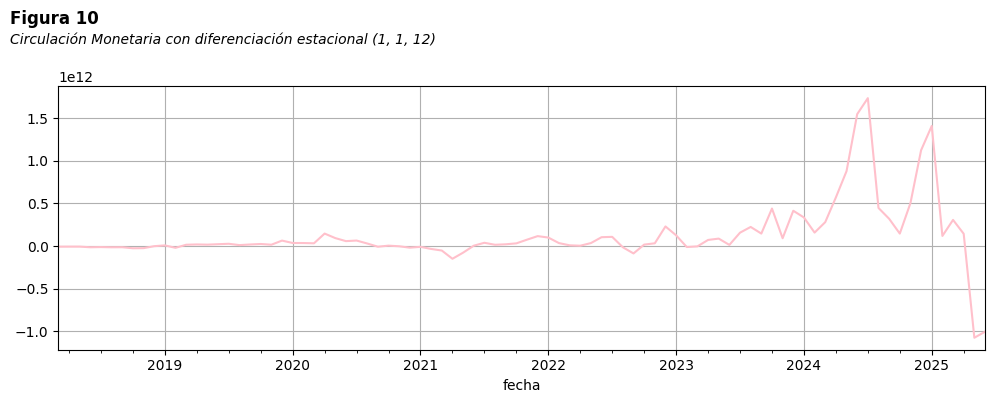

In [ ]:
serie_diff_seasonal = serie_diff.diff(12).dropna()

fig, ax = plt.subplots(figsize=(10, 4))
serie_diff_seasonal.plot(ax=ax, color='pink')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 10", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria con diferenciación estacional (1, 1, 12)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

**Transformación logarítmica**

In [ ]:
serie_log = np.log(serie)

**Diferencias regular de la transformación logarítmica**


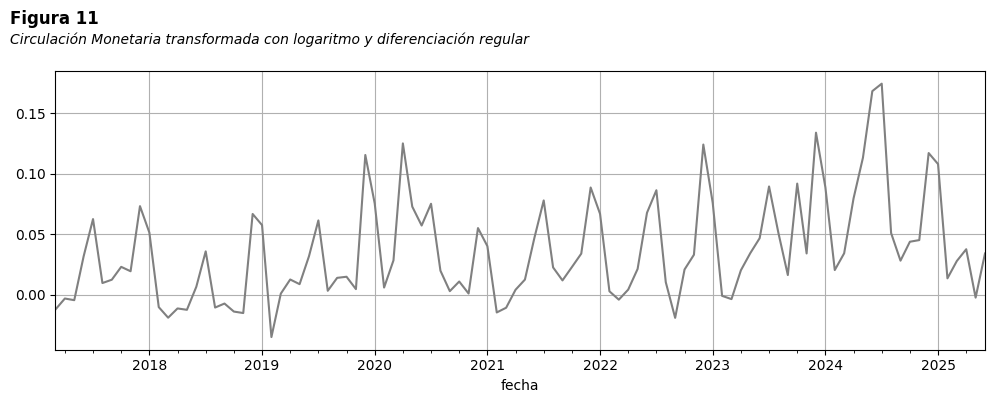

In [ ]:
serie_log_diff1 = serie_log.diff().dropna()

fig, ax = plt.subplots(figsize=(10, 4))
serie_log_diff1.plot(ax=ax, color='gray')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 11", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria transformada con logaritmo y diferenciación regular", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

**Diferencias estacional (1, 1, 6) de la transformación logarítmica**


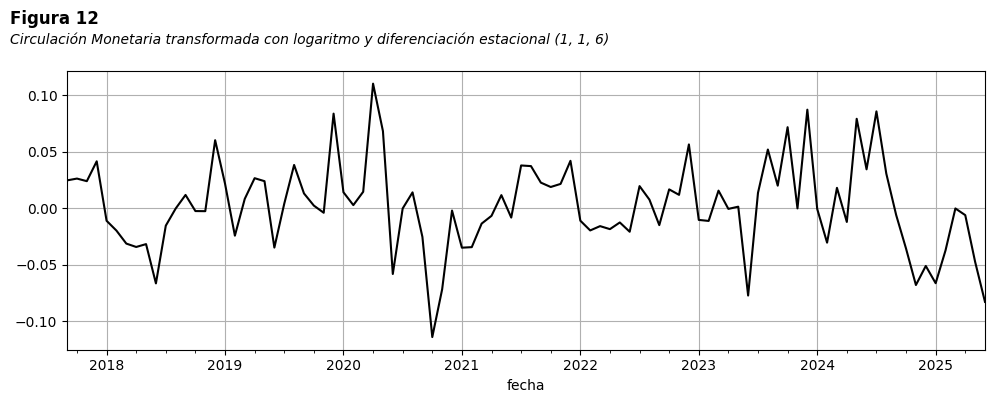

In [ ]:
serie_log_diff_seasonal_6 = serie_log_diff1.diff(6).dropna()
fig, ax = plt.subplots(figsize=(10, 4))
serie_log_diff_seasonal_6.plot(ax=ax, color='black')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 12", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria transformada con logaritmo y diferenciación estacional (1, 1, 6)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

**Diferencias estacional (1, 1, 12) de la transformación logarítmica**


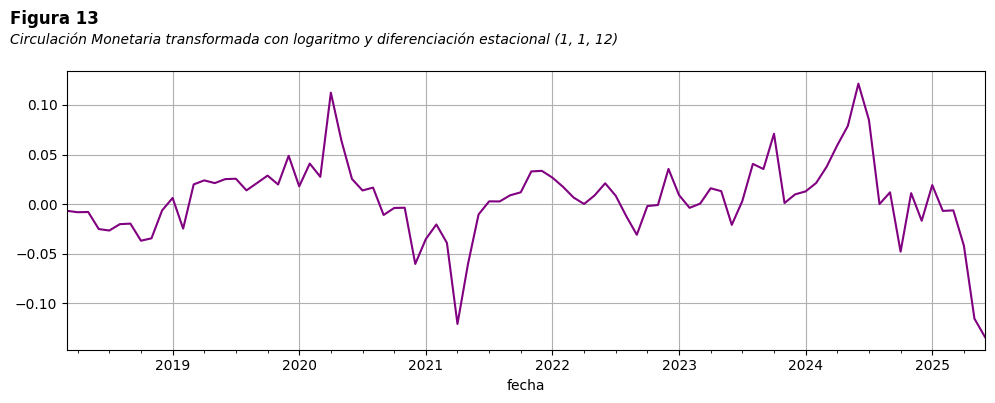

In [ ]:
serie_log_diff_seasonal = serie_log_diff1.diff(12).dropna()

fig, ax = plt.subplots(figsize=(10, 4))
serie_log_diff_seasonal.plot(ax=ax, color='purple')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 13", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria transformada con logaritmo y diferenciación estacional (1, 1, 12)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

### Tests de raíces unitarias para series transformadas

In [ ]:
series_transformadas = {
    'Diferenciación Regular (d=1)': serie_diff,
    'Diferenciación Estacional (1, 1, 12)': serie_diff_seasonal,
    'Log + Diferenciación Regular': serie_log_diff1,
    'Log + Diferenciación Estacional (1, 1, 6)': serie_log_diff_seasonal_6,
    'Log + Diferenciación Estacional (1, 1, 12)': serie_log_diff_seasonal
}

tabla2 = aplicar_tests_a_series(series_transformadas, nombre_columna='Transformación')
tabla2_larga = reorganizar_resultados_largo(tabla2, nombre_columna='Transformación')
mostrar_tabla_resultados(tabla2_larga, "<b>Tabla 2</b><br><i>Tests de raíces unitarias para series transformadas</i>", nombre_columna='Transformación')

,Transformación,Significancia,DF estadístico,DF crítico,DF conclusión,ADF estadístico,ADF p-valor,ADF crítico,ADF conclusión,KPSS estadístico,KPSS p-valor,KPSS crítico,KPSS conclusión
0,Diferenciación Regular (d=1),1%,-4.1064,-3.4300,Estacionaria,-5.6720,0.0000,-3.5079,Estacionaria,1.0296,0.0100,0.7390,No Estacionaria
1,Diferenciación Regular (d=1),5%,-4.1064,-2.8600,Estacionaria,-5.6720,0.0000,-2.8954,Estacionaria,1.0296,0.0100,0.4630,No Estacionaria
2,Diferenciación Regular (d=1),10%,-4.1064,-2.5700,Estacionaria,-5.6720,0.0000,-2.5848,Estacionaria,1.0296,0.0100,0.3470,No Estacionaria
3,"Diferenciación Estacional (1, 1, 12)",1%,-3.1004,-3.4300,Estacionaria,-4.8749,0.0000,-3.5183,Estacionaria,0.4941,0.0430,0.7390,No Estacionaria
4,"Diferenciación Estacional (1, 1, 12)",5%,-3.1004,-2.8600,Estacionaria,-4.8749,0.0000,-2.8999,Estacionaria,0.4941,0.0430,0.4630,No Estacionaria
5,"Diferenciación Estacional (1, 1, 12)",10%,-3.1004,-2.5700,Estacionaria,-4.8749,0.0000,-2.5872,Estacionaria,0.4941,0.0430,0.3470,No Estacionaria
6,Log + Diferenciación Regular,1%,-6.0191,-3.4300,Estacionaria,-2.5167,0.1115,-3.5079,No Estacionaria,0.9319,0.0100,0.7390,No Estacionaria
7,Log + Diferenciación Regular,5%,-6.0191,-2.8600,Estacionaria,-2.5167,0.1115,-2.8954,No Estacionaria,0.9319,0.0100,0.4630,No Estacionaria
8,Log + Diferenciación Regular,10%,-6.0191,-2.5700,Estacionaria,-2.5167,0.1115,-2.5848,No Estacionaria,0.9319,0.0100,0.3470,No Estacionaria
9,"Log + Diferenciación Estacional (1, 1, 6)",1%,-6.0357,-3.4300,Estacionaria,-3.5667,0.0064,-3.5127,Estacionaria,0.0778,0.1000,0.7390,Estacionaria


### Estimación de los coeficientes de los modelos y análisis de diagnóstico de los residuos

Separación de datos de entrenamiento.

- Meses de prueba: últimos 12.
- Meses de entrenamiento: Todos los anteriores.

In [ ]:
n_test = 12
train = serie_log.iloc[:-n_test]
test = serie_log.iloc[-n_test:]

Modelo SARIMA con diferenciación regular y estacional semestral sobre la serie logarítmica.

In [ ]:
modelo1 = sm.tsa.SARIMAX(
    train,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 1, 6),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_6 = modelo1.fit(disp=False)
resid_6 = resultado_6.resid
resid_std_6 = (resid_6 - resid_6.mean()) / resid_6.std()
print(resultado_6.summary())

                                     SARIMAX Results                                     
Dep. Variable:             circulacion_monetaria   No. Observations:                   89
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                 160.290
Date:                           Thu, 24 Jul 2025   AIC                           -312.579
Time:                                   18:44:22   BIC                           -303.363
Sample:                               02-01-2017   HQIC                          -308.903
                                    - 06-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4909      0.124      3.948      0.000       0.247       0.735
ar.S.L6       -0.4520      0.128     -3.536

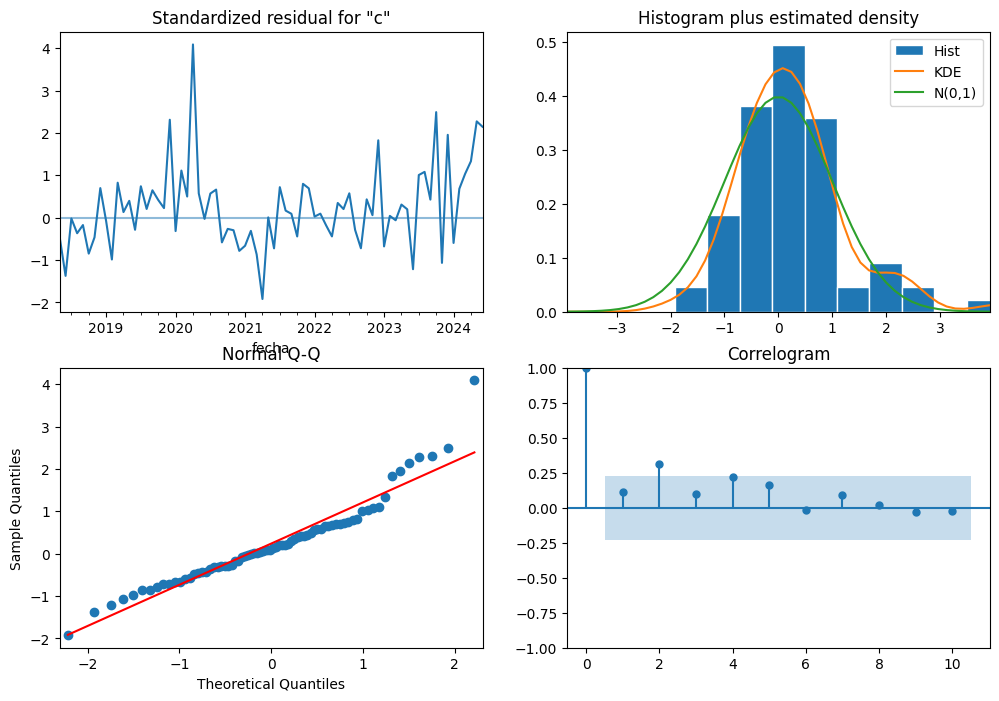

In [ ]:
fig = resultado_6.plot_diagnostics(figsize=(12, 8))
plt.show()

Modelo SARIMA con diferenciación regular y estacional anual sobre la serie logarítmica.

In [ ]:
modelo2 = sm.tsa.SARIMAX(
    train,
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_12 = modelo2.fit(disp=False)
resid_12 = resultado_12.resid
resid_std_12 = (resid_12 - resid_12.mean()) / resid_12.std()
print(resultado_12.summary())

                                     SARIMAX Results                                      
Dep. Variable:              circulacion_monetaria   No. Observations:                   89
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 132.252
Date:                            Thu, 24 Jul 2025   AIC                           -258.505
Time:                                    18:44:24   BIC                           -252.123
Sample:                                02-01-2017   HQIC                          -255.999
                                     - 06-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5437      0.123      4.409      0.000       0.302       0.785
ma.S.L12      -0.5557      0.147   

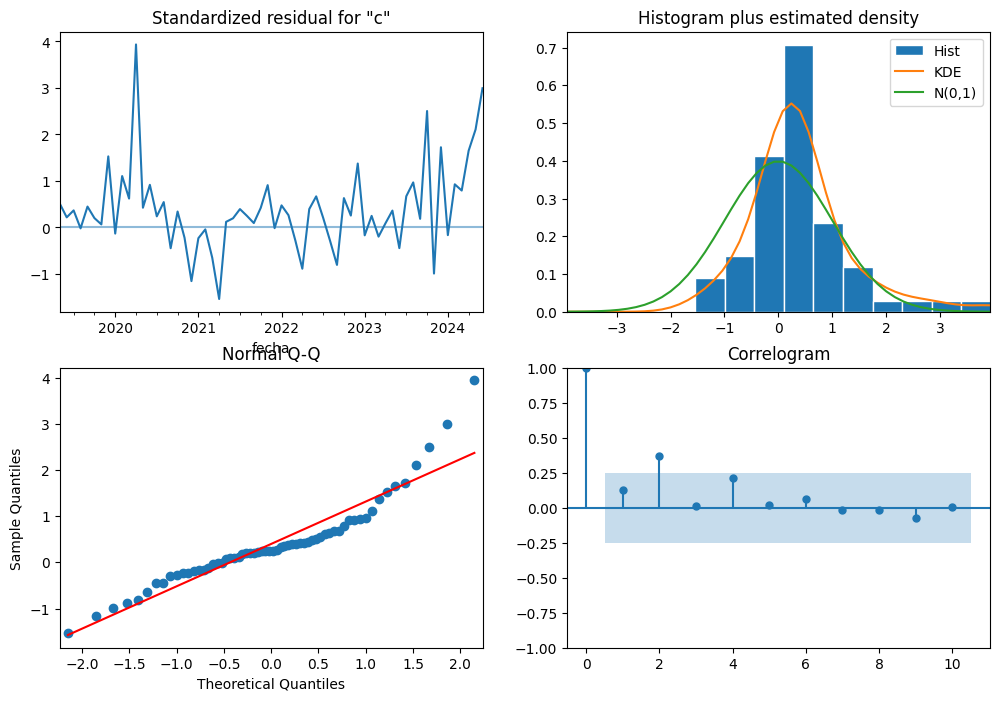

In [ ]:
fig = resultado_12.plot_diagnostics(figsize=(12, 8))
plt.show()

### Pronóstico a partir del modelo seleccionado y comparación con otros modelos

In [ ]:
n_test = len(test)
test_original = np.exp(test)

Modelo SARIMA (0, 1, 1) (1, 1, 1, 6).


In [ ]:
pred_6 = resultado_6.get_forecast(steps=n_test)
pred_mean_log_6 = pred_6.predicted_mean
pred_std_log_6 = pred_6.se_mean
pred_ci_log_6 = pred_6.conf_int()

pred_mean_6 = np.exp(pred_mean_log_6)
pred_ci_6 = np.exp(pred_ci_log_6)

pred_upper_1sd = np.exp(pred_mean_log_6 + pred_std_log_6)
pred_lower_1sd = np.exp(pred_mean_log_6 - pred_std_log_6)
pred_upper_2sd = np.exp(pred_mean_log_6 + 2 * pred_std_log_6)
pred_lower_2sd = np.exp(pred_mean_log_6 - 2 * pred_std_log_6)

In [ ]:
mse_6 = mean_squared_error(test_original, pred_mean_6)
rmse_6 = np.sqrt(mse_6)
mae_6 = mean_absolute_error(test_original, pred_mean_6)
mape_6 = np.mean(np.abs((test_original - pred_mean_6) / test_original)) * 100

print(f"📉 RMSE (escala original): $ {rmse_6:,.0f}")
print(f"📉 MAE  (escala original): $ {mae_6:,.0f}")
print(f"📉 MAPE (escala original): {mape_6:.2f}%")

📉 RMSE (escala original): $ 1,543,616,752,305
📉 MAE  (escala original): $ 1,418,923,817,818
📉 MAPE (escala original): 7.79%


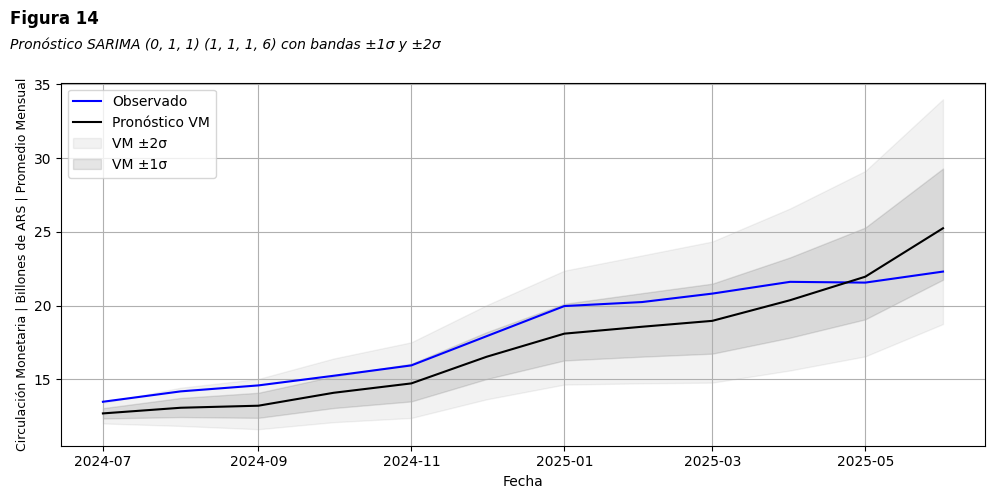

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.plot(test_original.index, test_original, label='Observado', color='blue')
ax.plot(pred_mean_6.index, pred_mean_6, label='Pronóstico VM', color='black')
ax.fill_between(test_original.index, pred_lower_2sd, pred_upper_2sd,
                color='black', alpha=0.05, label='VM ±2σ')
ax.fill_between(test_original.index, pred_lower_1sd, pred_upper_1sd,
                color='black', alpha=0.10, label='VM ±1σ')
ax.set_xlabel("Fecha")
ax.set_ylabel("Circulación Monetaria | Billones de ARS | Promedio Mensual", fontsize=9)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e12)}'))
ax.legend()
ax.grid(True)

fig.text(0.01, 0.96, "Figura 14", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Pronóstico SARIMA (0, 1, 1) (1, 1, 1, 6) con bandas ±1σ y ±2σ",
         fontsize=10, style='italic', ha='left')

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

Modelo SARIMA (0, 1, 1) (0, 1, 1, 12).


In [ ]:
pred_12 = resultado_12.get_forecast(steps=n_test)
pred_mean_log_12 = pred_12.predicted_mean
pred_std_log_12 = pred_12.se_mean
pred_ci_log_12 = pred_12.conf_int()

pred_mean_12 = np.exp(pred_mean_log_12)
pred_ci_12 = np.exp(pred_ci_log_12)

pred_upper_1sd = np.exp(pred_mean_log_12 + pred_std_log_12)
pred_lower_1sd = np.exp(pred_mean_log_12 - pred_std_log_12)
pred_upper_2sd = np.exp(pred_mean_log_12 + 2 * pred_std_log_12)
pred_lower_2sd = np.exp(pred_mean_log_12 - 2 * pred_std_log_12)

In [ ]:
mse_12 = mean_squared_error(test_original, pred_mean_12)
rmse_12 = np.sqrt(mse_12)
mae_12 = mean_absolute_error(test_original, pred_mean_12)
mape_12 = np.mean(np.abs((test_original - pred_mean_12) / test_original)) * 100

print(f"📉 RMSE (escala original): $ {rmse_12:,.0f}")
print(f"📉 MAE  (escala original): $ {mae_12:,.0f}")
print(f"📉 MAPE (escala original): {mape_12:.2f}%")

📉 RMSE (escala original): $ 1,875,118,184,716
📉 MAE  (escala original): $ 1,658,585,862,741
📉 MAPE (escala original): 8.96%


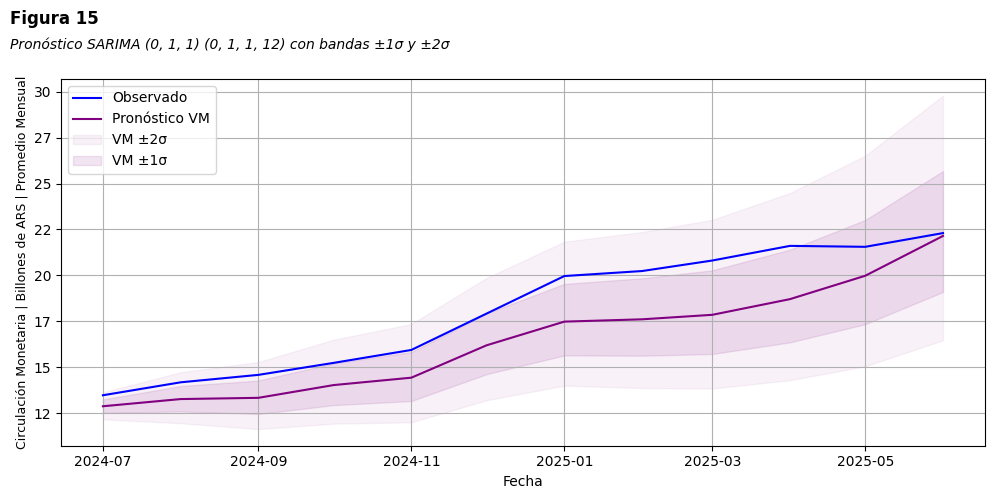

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.plot(test_original.index, test_original, label='Observado', color='blue')
ax.plot(pred_mean_12.index, pred_mean_12, label='Pronóstico VM', color='purple')
ax.fill_between(test_original.index, pred_lower_2sd, pred_upper_2sd,
                color='purple', alpha=0.05, label='VM ±2σ')
ax.fill_between(test_original.index, pred_lower_1sd, pred_upper_1sd,
                color='purple', alpha=0.10, label='VM ±1σ')
ax.set_xlabel("Fecha")
ax.set_ylabel("Circulación Monetaria | Billones de ARS | Promedio Mensual", fontsize=9)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e12)}'))
ax.legend()
ax.grid(True)

fig.text(0.01, 0.96, "Figura 15", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Pronóstico SARIMA (0, 1, 1) (0, 1, 1, 12) con bandas ±1σ y ±2σ",
         fontsize=10, style='italic', ha='left')

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

In [ ]:
resultados_modelos = pd.DataFrame([
    {
        "Modelo": "SARIMA (0, 1, 1) (1, 1, 1, 6)",
        "RMSE": f"$ {rmse_6:,.0f}",
        "MAE": f"$ {mae_6:,.0f}",
        "MAPE (%)": f"{mape_6:.2f}%"
    },
    {
        "Modelo": "SARIMA (0, 1, 1) (0, 1, 1, 12)",
        "RMSE": f"$ {rmse_12:,.0f}",
        "MAE": f"$ {mae_12:,.0f}",
        "MAPE (%)": f"{mape_12:.2f}%"
    }
])

mostrar_tabla_resultados(
    resultados_modelos,
    "<b>Tabla 3</b><br><i>Comparación de desempeño de modelos SARIMA</i>",
    nombre_columna="Modelo"
)

,Modelo,RMSE,MAE,MAPE (%)
0,"SARIMA (0, 1, 1) (1, 1, 1, 6)","$ 1,543,616,752,305","$ 1,418,923,817,818",7.79%
1,"SARIMA (0, 1, 1) (0, 1, 1, 12)","$ 1,875,118,184,716","$ 1,658,585,862,741",8.96%


### Modelo SARIMA-X

Transformaciones necesarias para contar con todas las variables para el modelo.

In [ ]:
def test_adf(serie, nombre):
    resultado = adfuller(serie.dropna())
    print(f"📊 ADF Test - {nombre}")
    print(f"  ➤ Estadístico ADF: {resultado[0]:.4f}")
    print(f"  ➤ p-value: {resultado[1]:.4f}")
    print("  📉 La serie es estacionaria" if resultado[1] < 0.05 else "  ⚠️ La serie NO es estacionaria", "\n")

test_adf(ipc_mensual['ipc'], 'IPC')
test_adf(emae_df['emae'], 'EMAE')
test_adf(tasa_pf_mensual, 'Tasa de Plazo Fijo')

log_emae = np.log(emae_df['emae'])
log_ipc = np.log(ipc_mensual['ipc'])
log_tasa = np.log(tasa_pf_mensual)

emae_diff = log_emae.diff().diff().dropna()
ipc_diff = log_ipc.diff().diff().dropna()
tasa_diff = log_tasa.diff().diff().dropna()

test_adf(ipc_diff, 'IPC log diff')
test_adf(emae_diff, 'EMAE log diff')
test_adf(tasa_diff, 'Tasa PF diff')

📊 ADF Test - IPC
  ➤ Estadístico ADF: -2.5708
  ➤ p-value: 0.0992
  ⚠️ La serie NO es estacionaria 

📊 ADF Test - EMAE
  ➤ Estadístico ADF: -1.8541
  ➤ p-value: 0.3539
  ⚠️ La serie NO es estacionaria 

📊 ADF Test - Tasa de Plazo Fijo
  ➤ Estadístico ADF: -2.3915
  ➤ p-value: 0.1442
  ⚠️ La serie NO es estacionaria 

📊 ADF Test - IPC log diff
  ➤ Estadístico ADF: -4.8218
  ➤ p-value: 0.0000
  📉 La serie es estacionaria 

📊 ADF Test - EMAE log diff
  ➤ Estadístico ADF: -6.3905
  ➤ p-value: 0.0000
  📉 La serie es estacionaria 

📊 ADF Test - Tasa PF diff
  ➤ Estadístico ADF: -5.7316
  ➤ p-value: 0.0000
  📉 La serie es estacionaria 



In [ ]:
log_y = np.log(circulacion_mensual)
log_emae = np.log(emae_df['emae'])
log_ipc = np.log(ipc_mensual['ipc'])
log_tasa = np.log(tasa_pf_mensual)

X = pd.concat([log_emae, log_ipc, log_tasa], axis=1)
X.columns = ['emae', 'ipc', 'tasa_pf']
y, X = log_y.align(X, join='inner')

Separación de datos de entrenamiento.

- Meses de prueba: últimos 12.
- Meses de entrenamiento: Todos los anteriores.


In [ ]:
n_test = 12
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]

X_test_clean = X_test.replace([np.inf, -np.inf], np.nan).dropna()
y_test_clean = y_test.loc[X_test_clean.index]

Entrenamiento del modelo y estimación de sus coeficientes.

In [ ]:
modelo_sarimax = sm.tsa.SARIMAX(
    y_train,
    exog=X_train,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 1, 6),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_sarimax = modelo_sarimax.fit(disp=False)
resid_sarimax = resultado_sarimax.resid
resid_std_sarimax = (resid_sarimax - resid_sarimax.mean()) / resid_sarimax.std()

print(resultado_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:             circulacion_monetaria   No. Observations:                   89
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                 165.938
Date:                           Thu, 24 Jul 2025   AIC                           -317.877
Time:                                   18:44:26   BIC                           -301.748
Sample:                               02-01-2017   HQIC                          -311.443
                                    - 06-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
emae          -0.0434      0.076     -0.575      0.565      -0.191       0.105
ipc           -0.0047      0.011     -0.428

Diagnóstico de los residuos.

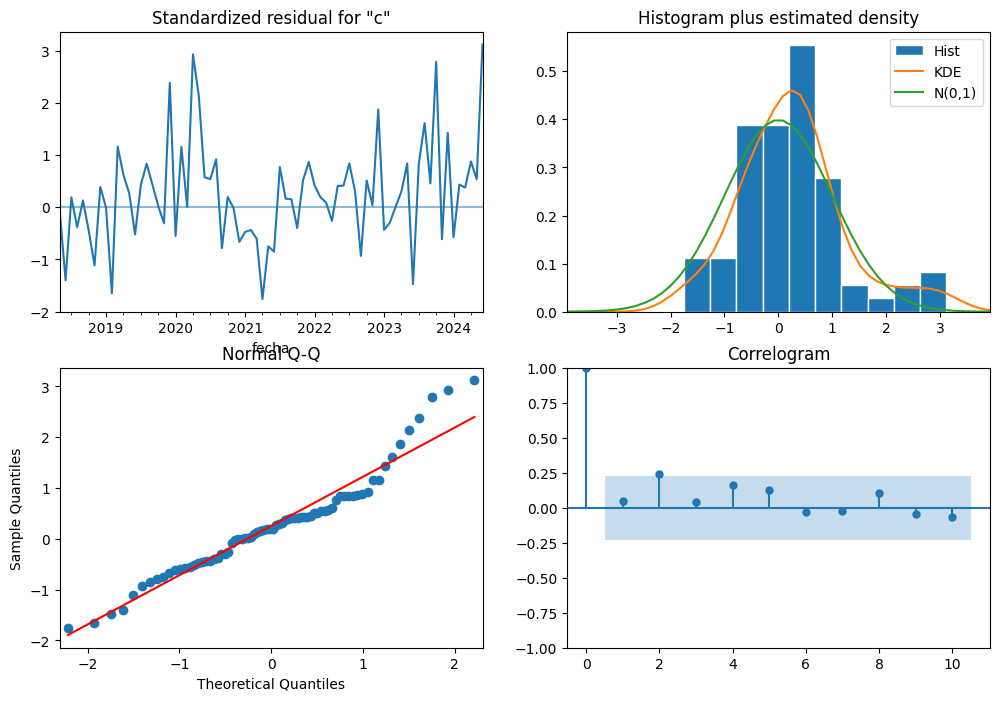

In [ ]:
fig = resultado_sarimax.plot_diagnostics(figsize=(12, 8))
plt.show()

Predicción


In [ ]:
forecast = resultado_sarimax.get_forecast(steps=len(X_test_clean), exog=X_test_clean)

se = forecast.se_mean
y_pred_log = forecast.predicted_mean

lower_1s = np.exp(y_pred_log - se)
upper_1s = np.exp(y_pred_log + se)
lower_2s = np.exp(y_pred_log - 2 * se)
upper_2s = np.exp(y_pred_log + 2 * se)
conf_int = forecast.conf_int()

Métricas de error en escala original


In [ ]:
y_pred = np.exp(y_pred_log)
y_real = np.exp(y_test_clean)
conf_int_exp = np.exp(conf_int)
lower = conf_int_exp.iloc[:, 0]
upper = conf_int_exp.iloc[:, 1]

rmse_sarimax_gral = np.sqrt(mean_squared_error(y_real, y_pred))
mae_sarimax_gral = mean_absolute_error(y_real, y_pred)
mape_sarimax_gral = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

print(f"✅ RMSE: ${rmse_sarimax_gral:,.0f}")
print(f"✅ MAE : ${mae_sarimax_gral:,.0f}")
print(f"✅ MAPE: {mape_sarimax_gral:.2f}%")

✅ RMSE: $1,381,685,827,126
✅ MAE : $1,330,541,670,495
✅ MAPE: 7.59%


Visualización


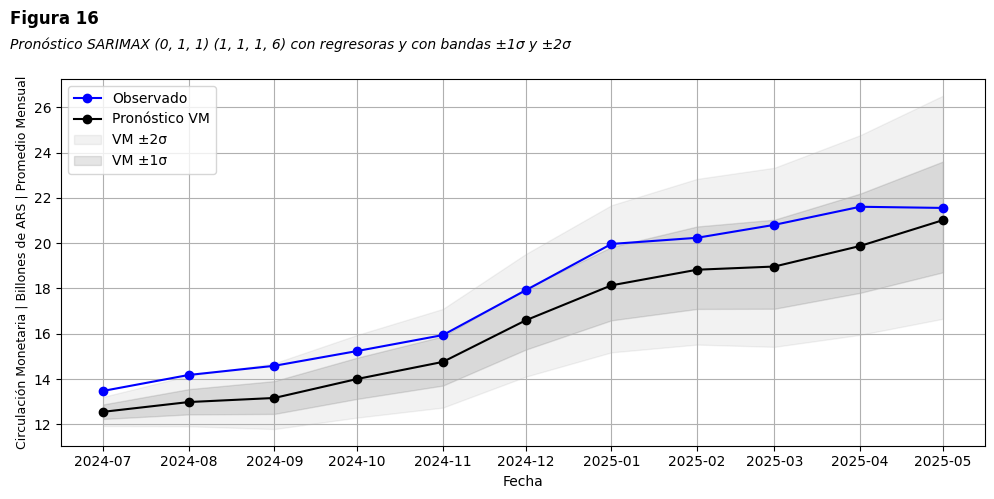

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(y_real.index, y_real, label='Observado', color='blue', marker='o')
ax.plot(y_pred.index, y_pred, label='Pronóstico VM', color='black', marker='o')
ax.fill_between(y_pred.index, lower_2s, upper_2s, color='black', alpha=0.05, label='VM ±2σ')
ax.fill_between(y_pred.index, lower_1s, upper_1s, color='black', alpha=0.1, label='VM ±1σ')
ax.set_xlabel("Fecha")
ax.set_ylabel("Circulación Monetaria | Billones de ARS | Promedio Mensual", fontsize=9)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e12)}'))
ax.legend()
ax.grid(True)
fig.text(0.01, 0.96, "Figura 16", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Pronóstico SARIMAX (0, 1, 1) (1, 1, 1, 6) con regresoras y con bandas ±1σ y ±2σ",
         fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

Modelos alternativos solo con logaritmo de tasa de plazo fijo como regresora.

Entrenamiento de los modelos y estimación de sus coeficientes.

Modelo SARIMA-X(0,1,1)  (1,1,1,6)

In [ ]:
y = np.log(circulacion_mensual)
log_tasa = np.log(tasa_pf_mensual)

y_alineado, X_alineado = y.align(log_tasa, join='inner')
X_alineado.name = 'tasa_pf'

n_test = 12
y_train = y_alineado.iloc[:-n_test]
y_test = y_alineado.iloc[-n_test:]
X_train = X_alineado.iloc[:-n_test]
X_test = X_alineado.iloc[-n_test:]

modelo_6 = sm.tsa.SARIMAX(
    y_train, exog=X_train,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 1, 6),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_6 = modelo_6.fit()
resid_6 = resultado_6.resid
resid_std_6 = (resid_6 - resid_6.mean()) / resid_6.std()
print(res_6.summary())

                                     SARIMAX Results                                     
Dep. Variable:             circulacion_monetaria   No. Observations:                   89
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                 165.630
Date:                           Thu, 24 Jul 2025   AIC                           -321.260
Time:                                   18:44:28   BIC                           -309.739
Sample:                               02-01-2017   HQIC                          -316.664
                                    - 06-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tasa_pf       -0.0928      0.023     -4.100      0.000      -0.137      -0.048
ma.L1          0.3404      0.123      2.766

Diagnóstico de los residuos.

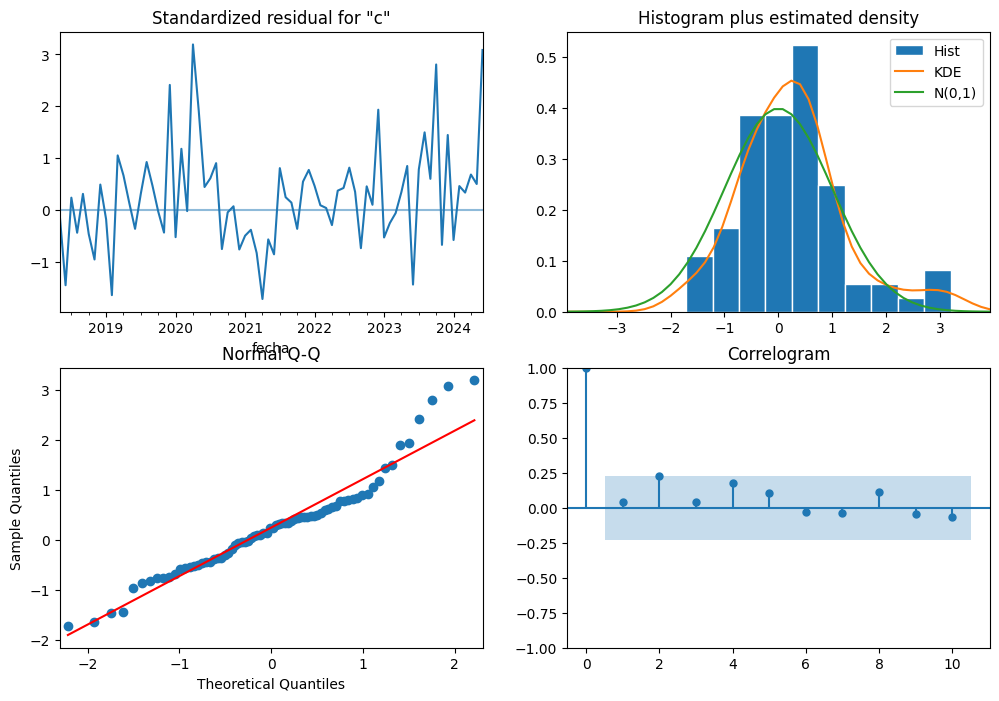

In [ ]:
fig = res_6.plot_diagnostics(figsize=(12, 8))
plt.show()

SARIMA-X(0,1,1) (1,1,1,12)

In [ ]:
modelo_12 = sm.tsa.SARIMAX(
    y_train, exog=X_train,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_12 = modelo_12.fit()

resid_12 = res_12.resid
resid_std_12 = (resid_12 - resid_12.mean()) / resid_12.std()
print(res_12.summary())

                                     SARIMAX Results                                      
Dep. Variable:              circulacion_monetaria   No. Observations:                   89
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 135.545
Date:                            Thu, 24 Jul 2025   AIC                           -261.090
Time:                                    18:44:29   BIC                           -250.455
Sample:                                02-01-2017   HQIC                          -256.914
                                     - 06-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tasa_pf       -0.1010      0.028     -3.591      0.000      -0.156      -0.046
ma.L1          0.3813      0.161   

Diagnóstico de los residuos.

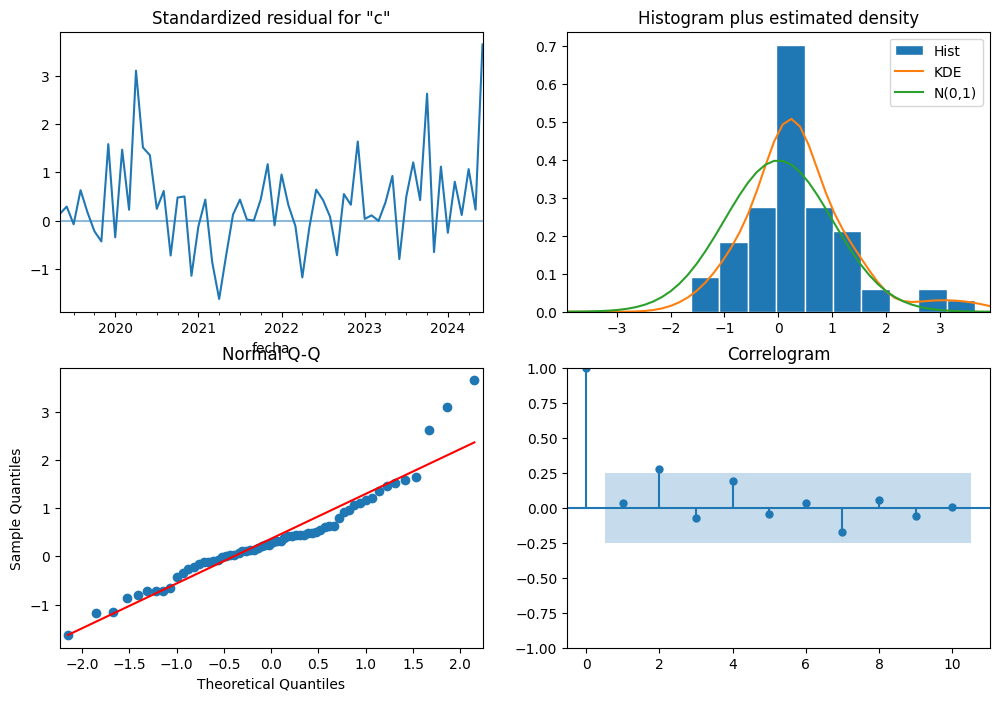

In [ ]:
fig = res_12.plot_diagnostics(figsize=(12, 8))
plt.show()

Predicción SARIMA-X(0,1,1) (1,1,1,6)

In [ ]:
forecast = res_6.get_forecast(steps=len(X_test), exog=X_test)

conf_int = forecast.conf_int()
se = forecast.se_mean
y_pred_log = forecast.predicted_mean

lower_1s = np.exp(y_pred_log - se)
upper_1s = np.exp(y_pred_log + se)
lower_2s = np.exp(y_pred_log - 2 * se)
upper_2s = np.exp(y_pred_log + 2 * se)

Métricas de error en escala original SARIMA-X(0,1,1) (1,1,1,6)

In [ ]:
y_real = np.exp(y_test)
y_pred = np.exp(y_pred_log)
conf_int_exp = np.exp(conf_int)
lower = conf_int_exp.iloc[:, 0]
upper = conf_int_exp.iloc[:, 1]

rmse_sarimax6 = np.sqrt(mean_squared_error(y_real, y_pred))
mae_sarimax6 = mean_absolute_error(y_real, y_pred)
mape_sarimax6 = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

print(f"📉 RMSE: ${rmse_sarimax6:,.0f}")
print(f"📉 MAE : ${mae_sarimax6:,.0f}")
print(f"📉 MAPE: {mape_sarimax6:.2f}%")

📉 RMSE: $1,479,605,676,990
📉 MAE : $1,436,729,584,104
📉 MAPE: 8.02%


Visualización SARIMA-X(0,1,1) (1,1,1,6)

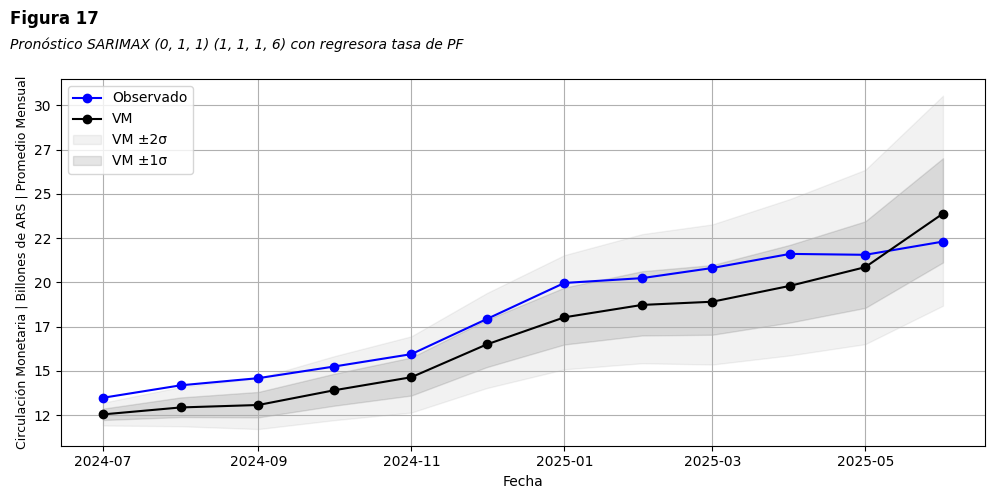

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(y_real.index, y_real, label='Observado', color='blue', marker='o')
ax.plot(y_pred.index, y_pred, label='VM', color='black', marker='o')
ax.fill_between(y_pred.index, lower_2s, upper_2s, color='black', alpha=0.05, label='VM ±2σ')
ax.fill_between(y_pred.index, lower_1s, upper_1s, color='black', alpha=0.1, label='VM ±1σ')
ax.set_xlabel("Fecha")
ax.set_ylabel("Circulación Monetaria | Billones de ARS | Promedio Mensual", fontsize=9)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e12)}'))
ax.legend()
ax.grid(True)
fig.text(0.01, 0.96, "Figura 17", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Pronóstico SARIMAX (0, 1, 1) (1, 1, 1, 6) con regresora tasa de PF",
         fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

Predicción SARIMA-X(0,1,1) (1,1,1,12)

In [ ]:
forecast = res_12.get_forecast(steps=len(X_test), exog=X_test)

conf_int = forecast.conf_int()
se = forecast.se_mean
y_pred_log = forecast.predicted_mean

lower_1s = np.exp(y_pred_log - se)
upper_1s = np.exp(y_pred_log + se)
lower_2s = np.exp(y_pred_log - 2 * se)
upper_2s = np.exp(y_pred_log + 2 * se)

Métricas de error en escala original SARIMA-X(0,1,1) (1,1,1,12)

In [ ]:
y_pred = np.exp(y_pred_log)
y_real = np.exp(y_test)
conf_int_exp = np.exp(conf_int)
lower = conf_int_exp.iloc[:, 0]
upper = conf_int_exp.iloc[:, 1]

rmse_sarimax12 = np.sqrt(mean_squared_error(y_real, y_pred))
mae_sarimax12 = mean_absolute_error(y_real, y_pred)
mape_sarimax12 = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

print(f"📉 RMSE: ${rmse_sarimax12:,.0f}")
print(f"📉 MAE : ${mae_sarimax12:,.0f}")
print(f"📉 MAPE: {mape_sarimax12:.2f}%")

📉 RMSE: $1,428,146,815,775
📉 MAE : $1,302,375,670,403
📉 MAPE: 7.17%


Visualización SARIMA-X(0,1,1) (1,1,1,12)

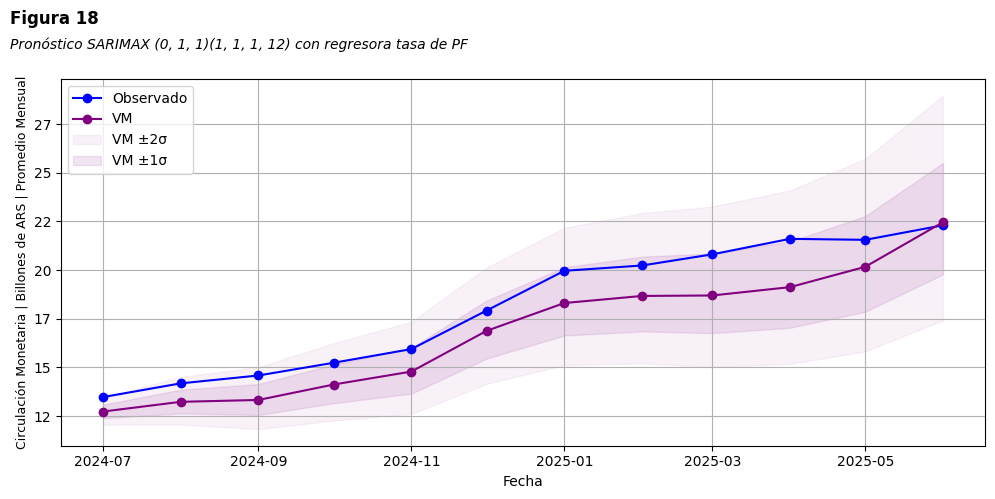

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(y_real.index, y_real, label='Observado', color='blue', marker='o')
ax.plot(y_pred.index, y_pred, label='VM', color='purple', marker='o')
ax.fill_between(y_pred.index, lower_2s, upper_2s, color='purple', alpha=0.05, label='VM ±2σ')
ax.fill_between(y_pred.index, lower_1s, upper_1s, color='purple', alpha=0.1, label='VM ±1σ')
ax.set_xlabel("Fecha")
ax.set_ylabel("Circulación Monetaria | Billones de ARS | Promedio Mensual", fontsize=9)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e12)}'))
ax.legend()
ax.grid(True)
fig.text(0.01, 0.96, "Figura 18", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Pronóstico SARIMAX (0, 1, 1)(1, 1, 1, 12) con regresora tasa de PF",
         fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

Comparación de métricas de los modelos SARIMA-X

In [ ]:
resultados_modelos_sarimax = pd.DataFrame([
    {
        "Modelo": "SARIMA-X (0, 1, 1) (1, 1, 1, 6)",
        "RMSE": f"$ {rmse_sarimax_gral:,.0f}",
        "MAE": f"$ {mae_sarimax_gral:,.0f}",
        "MAPE (%)": f"{mape_sarimax_gral:.2f}%"
    },
    {
        "Modelo": "SARIMA-X tasa_pf (0, 1, 1) (1, 1, 1, 6)",
        "RMSE": f"$ {rmse_sarimax6:,.0f}",
        "MAE": f"$ {mae_sarimax6:,.0f}",
        "MAPE (%)": f"{mape_sarimax6:.2f}%"
    },
    {
        "Modelo": "SARIMA-X tasa_pf (0, 1, 1) (1, 1, 1, 12)",
        "RMSE": f"$ {rmse_sarimax12:,.0f}",
        "MAE": f"$ {mae_sarimax12:,.0f}",
        "MAPE (%)": f"{mape_sarimax12:.2f}%"
    }
])

mostrar_tabla_resultados(
    resultados_modelos_sarimax,
    "<b>Tabla 4</b><br><i>Comparación de desempeño de modelos SARIMA-X</i>",
    nombre_columna="Modelo"
)

,Modelo,RMSE,MAE,MAPE (%)
0,"SARIMA-X (0, 1, 1) (1, 1, 1, 6)","$ 1,381,685,827,126","$ 1,330,541,670,495",7.59%
1,"SARIMA-X tasa_pf (0, 1, 1) (1, 1, 1, 6)","$ 1,479,605,676,990","$ 1,436,729,584,104",8.02%
2,"SARIMA-X tasa_pf (0, 1, 1) (1, 1, 1, 12)","$ 1,428,146,815,775","$ 1,302,375,670,403",7.17%


In [ ]:
resultados_modelos_sarima_sarimax = pd.DataFrame([
    {
        "Modelo": "SARIMA (0, 1, 1) (1, 1, 1, 6)",
        "RMSE": f"$ {rmse_6:,.0f}",
        "MAE": f"$ {mae_6:,.0f}",
        "MAPE (%)": f"{mape_6:.2f}%",
        "AIC": f"{resultado_6.aic:.2f}",
        "BIC": f"{resultado_6.bic:.2f}",
        "HQIC": f"{resultado_6.hqic:.2f}"
    },
    {
        "Modelo": "SARIMA (0, 1, 1) (0, 1, 1, 12)",
        "RMSE": f"$ {rmse_12:,.0f}",
        "MAE": f"$ {mae_12:,.0f}",
        "MAPE (%)": f"{mape_12:.2f}%",
        "AIC": f"{resultado_12.aic:.2f}",
        "BIC": f"{resultado_12.bic:.2f}",
        "HQIC": f"{resultado_12.hqic:.2f}"
    },
    {
        "Modelo": "SARIMA-X (0, 1, 1) (1, 1, 1, 6)",
        "RMSE": f"$ {rmse_sarimax_gral:,.0f}",
        "MAE": f"$ {mae_sarimax_gral:,.0f}",
        "MAPE (%)": f"{mape_sarimax_gral:.2f}%",
        "AIC": f"{resultado_sarimax.aic:.2f}",
        "BIC": f"{resultado_sarimax.bic:.2f}",
        "HQIC": f"{resultado_sarimax.hqic:.2f}"
    },
    {
        "Modelo": "SARIMA-X (0, 1, 1) (1, 1, 1, 6) con tasa_pf",
        "RMSE": f"$ {rmse_sarimax6:,.0f}",
        "MAE": f"$ {mae_sarimax6:,.0f}",
        "MAPE (%)": f"{mape_sarimax6:.2f}%",
        "AIC": f"{res_6.aic:.2f}",
        "BIC": f"{res_6.bic:.2f}",
        "HQIC": f"{res_6.hqic:.2f}"
    },
    {
        "Modelo": "SARIMA-X (0, 1, 1) (1, 1, 1, 12) con tasa_pf",
        "RMSE": f"$ {rmse_sarimax12:,.0f}",
        "MAE": f"$ {mae_sarimax12:,.0f}",
        "MAPE (%)": f"{mape_sarimax12:.2f}%",
        "AIC": f"{res_12.aic:.2f}",
        "BIC": f"{res_12.bic:.2f}",
        "HQIC": f"{res_12.hqic:.2f}"
    }
])

mostrar_tabla_resultados(
    resultados_modelos_sarima_sarimax,
    "<b>Tabla 5</b><br><i>Comparación de desempeño de modelos SARIMA y SARIMA-X</i>",
    nombre_columna="Modelo"
)

,Modelo,RMSE,MAE,MAPE (%),AIC,BIC,HQIC
0,"SARIMA (0, 1, 1) (1, 1, 1, 6)","$ 1,543,616,752,305","$ 1,418,923,817,818",7.79%,-312.58,-303.36,-308.90
1,"SARIMA (0, 1, 1) (0, 1, 1, 12)","$ 1,875,118,184,716","$ 1,658,585,862,741",8.96%,-258.50,-252.12,-256.00
2,"SARIMA-X (0, 1, 1) (1, 1, 1, 6)","$ 1,381,685,827,126","$ 1,330,541,670,495",7.59%,-317.88,-301.75,-311.44
3,"SARIMA-X (0, 1, 1) (1, 1, 1, 6) con tasa_pf","$ 1,479,605,676,990","$ 1,436,729,584,104",8.02%,-321.26,-309.74,-316.66
4,"SARIMA-X (0, 1, 1) (1, 1, 1, 12) con tasa_pf","$ 1,428,146,815,775","$ 1,302,375,670,403",7.17%,-261.09,-250.45,-256.91
